In [1]:
from __future__ import print_function
from copy import deepcopy
from scipy.io.wavfile import read as wavread
import scipy.signal as signal
import librosa, os, numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

/home/tim/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
old_data = []
data = []
srs = []
offsets = []
onset_times = []

def getwindow(center, windowsize):
    if type(windowsize) is int:
        return np.arange(center-windowsize, center+windowsize)
    else:
        return np.arange(center+windowsize[0], center+windowsize[1])
    
def tts(t, sr=44100):
        return [int(ts*sr) for ts in t]  if isinstance(t, (tuple, list)) else int(t*sr)

def stt(sample, sr=44100):
    return [s/float(sr) for s in sample] if isinstance(sample, (tuple, list)) else sample/float(sr) 

def newfig(w=40,h=40, **kwargs):
    return plt.figure(figsize=(w,h),**kwargs)

def loadfiles(path="./data/1_aligned", clip_intro=0):
    global data, old_data, srs, offsets, onset_times
    data = []
    srs = []
    offsets = []
    onset_times = []
    datadir = os.path.abspath(path)
    print("Using recordings from %s" % (datadir))
    
    data=[]
    srs=[]
    for file in os.listdir(datadir):
        if file.endswith('.wav'):
            (sr,dat) = wavread(os.path.join(datadir,file))
            if len(dat.shape) > 1:
                dat = dat[:,0]
            if clip_intro > 0:
                dat = dat[tts(clip_intro):]
            dat = dat.astype(np.float32)/np.max(dat)
            data.append(dat)
            srs.append(sr)
            onset_times.append(librosa.onset.onset_detect(dat,units="samples",sr=sr, backtrack=False))
            offsets.append(0)
            print("loaded %s" % file)
    old_data=[np.copy(dat) for dat in data]

datafolder = os.path.abspath("./data")
options = {run:os.path.join(datafolder,run) for run in os.listdir(datafolder) if os.path.isdir(os.path.join(datafolder,run)) }
loader=interactive(loadfiles,path=options, clip_intro=(0,65,0.5)) 
display(loader)

interactive(children=(Dropdown(description='path', options={'run_1': '/home/tim/Class/meen_698/acoustic-locali…

In [3]:
def onset_ex(which=0,windowsize=1.0, center=1.0, back_track=False):
    global onset_times
    ww = getwindow(tts(center),tts(windowsize))
    clip = data[which][ww]
    onsets = librosa.onset.onset_detect(data[which],units="samples",sr=srs[which],
                                             backtrack=back_track)
    print("plot centered at %f (%d, %d to %d)" %
          (center,tts(center),tts(center-windowsize), tts(center+windowsize)))
    plt.plot(np.linspace(stt(ww[0]), stt(ww[-1]), len(clip)),clip)
    ost_in_window = onsets[np.logical_and(onsets >= ww[0], onsets <= ww[-1])]
    plt.vlines(stt(ost_in_window), -1,1, 'r')
    plt.ylim(-1,1)
    print("avg onset rate is %fHz" % (1/stt(np.mean(np.diff(ost_in_window)))))
#     onset_times = ost_in_window

options = {b:a-1 for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])}
onset_example = interactive(onset_ex, {'manual':False}, which=options,
                            windowsize=(.1,10,.05),
                            center=(0.250,stt(min([len(a) for a in data])), 0.050),
                            back_track=False)
sl1 = onset_example.children[1]
sl2 = onset_example.children[2]
sl2.continuous_update=False
def update_center_slider(*args):
    sl2.min = max(sl2.value-3*sl1.value, sl1.value)
    sl2.max = sl2.value+3*sl1.value
sl2.observe(update_center_slider, 'value')
sl1.observe(update_center_slider, 'value')
onset_example

interactive(children=(Dropdown(description='which', index=1, options={'1': -1, '2': 0, '3': 1, '4': 2}, value=…

In [4]:
def filt(wl=10, wh= 500, typ='bandstop', order=5, which=0, sz=0.5):
    global data, old_data
#     data = [np.copy(dat) for dat in old_data]
    wl *=2*np.pi
    wh *=2*np.pi
    if typ=='none':
        return
    elif typ=='highpass':
        b, a = signal.butter(order, wh, btype=typ, fs=44100)
    elif typ=='lowpass':
        b, a = signal.butter(order, wl, btype=typ, fs=44100)
    else:
        b, a = signal.butter(order, (wl,wh), btype=typ, fs=44100)
    
    windw = getwindow(int(np.mean(onset_times[0][2:10])), tts(sz))
    sig = data[which][windw]
    fsig = signal.filtfilt(b,a,sig)
    fsig*=np.max(sig)/np.max(fsig)
    newfig(h=5)   
    plt.plot(stt(windw) - offsets[which],sig)
    plt.plot(stt(windw) - offsets[which],fsig)
    plt.xlim([stt(windw[0]), stt(windw[-1])])
    plt.ylim([-0.1, 0.1])

wnl = widgets.FloatLogSlider(
    value=10,
    base=10,
    min=0,
    max=4,
    step=0.1,
    description='low freq:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f')
order = widgets.IntSlider(
    value=3,
    min=0,
    max=10,
    step=1,
    description='filter order:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f')
wnh = widgets.FloatLogSlider(
    value=500,
    base=10,
    min=2,
    max=np.log(44100)/2,
    step=0.1,
    description='high freq:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
wndsz = widgets.FloatLogSlider(
    value=0.25,
    base=10,
    min=-2,
    max=3,
    step=0.05,
    description='window width:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
filt_butt = widgets.ToggleButtons(
    options = ['lowpass', 'highpass', 'bandpass', 'bandstop', 'none'],
    value='bandstop',
    description='filter type:',
    disabled=False,)
sig_select = widgets.Dropdown(
    options={b:a for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])},
    value=0,
    description='Refernce wav:',
    disabled=False)
filterbtn = widgets.Button(
    description='filter all',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='save filter settings',
    icon='check')

def filter_all(*args):
    global data, old_data
    data = [np.copy(dat) for dat in old_data]
    wl = wnl.value*2*np.pi
    wh = wnh.value*2*np.pi
    typ=filt_butt.value
    ordr = order.value
    if typ=='none':
        return
    elif typ=='highpass':
        b, a = signal.butter(ordr, wh, btype=typ, fs=44100)
    elif typ=='lowpass':
        b, a = signal.butter(ordr, wl, btype=typ, fs=44100)
    else:
        b, a = signal.butter(ordr, (wl,wh), btype=typ, fs=44100)
    
    for d in range(len(data)):
        data[d] = signal.filtfilt(b,a,data[d])
        data[d]*=np.max(old_data[d])/np.max(data[d])

filterbtn.on_click(filter_all)
options = ['lowpass', 'highpass', 'bandpass', 'bandstop']
filtex = widgets.interactive_output(filt,{'wl':wnl, 'wh':wnh, 'typ':filt_butt, 'order':order, 'which':sig_select, 'sz':wndsz})
display(widgets.VBox([widgets.HBox([filt_butt, sig_select,filterbtn]), widgets.HBox([wnl,wnh, order, wndsz])]),filtex)

#best filter so far has been highpass 650Hz

Output()

In [14]:
ref = 0
x_ax_align = []
y_ax_align = []
offsets= [0 for k in offsets] 
def do_settings_align(reference, lns, wrl, wrh, yr, oc, pr, **kwargs):
    global ref, lines, scale, x_ax_align, y_ax_align
    ref = reference
    x_ax_align = [wrl, wrh]
    y_ax_align = yr
    plot(oc,pr,lns,x_ax_align, y_ax_align, reference)

def plot(plot_onsets=True, plot_ref=True, lines = [], x_ax = x_ax_align, y_ax=y_ax_align,ref=0, **kwargs):
    ww = np.arange(tts(x_ax[0]), tts(x_ax[1]))
    f = plt.figure(figsize = (40,10))
    rc = np.ceil(np.sqrt(len(data)))
    for ln in lines:
        plt.subplot(rc,rc,ln+1)
        ofs = tts(offsets[ln])
        clip = data[ln][ww+ofs]
        plt.plot(np.linspace(stt(ww[0]),stt(ww[-1]),len(clip)),clip)
        if plot_onsets:
            plt.vlines(stt(onset_times[ref]), -1, 1, 'r')
        if plot_ref:
            rr = data[ref][ww + tts(offsets[ref])] 
            plt.plot(np.linspace(stt(ww[0]),stt(ww[-1]),len(rr)),rr, 'k', alpha=0.7)
        plt.xlim(x_ax)
        plt.ylim(y_ax)

ref_select = widgets.Dropdown(
    options={b:a for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])},
    value=0,
    description='Refernce wav:',
    disabled=False)
lines_select = widgets.SelectMultiple(
    options={b:a for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])},
    value=[0],
    description='Wavs to plot',
    disabled=False)
w_range_low = widgets.FloatSlider(
    value=0,
    min=0,
    max=stt(len(data[0])),
    step=0.001,
    description='Lower Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
w_range_high = widgets.FloatSlider(
    value=stt(len(data[0])),
    min=0,
    max=stt(len(data[0])),
    step=0.001,
    description='Upper Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
scale_buttons = widgets.ToggleButtons(
    options=['full','coarse', 'med', 'fine', 'ultrafine'],
    value='full',
    description='scrub speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['1','2','3'])
y_range = widgets.FloatRangeSlider(
    value=[-1, 1],
    min=-1,
    max=1,
    step=0.05,
    description='Vertical range:',
    disabled=False,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    readout_format='.4f')
onset_cb = widgets.Checkbox(
    value=True,
    description='Plot Onsets',
    disabled=False,
    indent=False)
overlay_cb = widgets.Checkbox(
    value=True,
    description='Plot Ref',
    disabled=False,
    indent=False)
replot_button = widgets.ToggleButton(
    value=False,
    description='replot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def update_range_low(*args):
    if scale_buttons.value == scale_buttons.options[0]:
        w_range_low.min = 0
        w_range_low.max = min(stt(len(data[ref])), w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[1]:
        scl = 15
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[2]:
        scl = 5
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[3]:
        scl = 0.25
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[4]:
        scl = 0.01
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
        
def update_range_high(*args):
    if scale_buttons.value == scale_buttons.options[0]:
        w_range_high.min = max(0,stt(w_range_low.value))
        w_range_high.max = stt(len(data[ref]))
    elif scale_buttons.value == scale_buttons.options[1]:
        scl = 15
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))
    elif scale_buttons.value == scale_buttons.options[2]:
        scl = 5
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))
    elif scale_buttons.value == scale_buttons.options[3]:
        scl = 0.25
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))
    elif scale_buttons.value == scale_buttons.options[4]:
        scl = 0.01
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))

def update_wrange(*args):
    update_range_low()
    update_range_high()
    
lb = widgets.VBox([ref_select, lines_select])
rb = widgets.VBox([w_range_low,w_range_high, onset_cb, overlay_cb, replot_button])
# rb.layout.width = '50%'
y_range.layout.width='100px'
ui = widgets.HBox([lb, rb, y_range, scale_buttons])
ui.layout.width='100%'
out = widgets.interactive_output(do_settings_align, {'reference':ref_select,
                                               'lns':lines_select,
                                               'wrl':w_range_low,
                                               'wrh':w_range_high,
                                               'yr':y_range,
                                               'oc':onset_cb,
                                               'pr':overlay_cb,
                                               'rp':replot_button
                                              })

scale_buttons.observe(update_wrange, 'value')
w_range_low.observe(update_range_high, 'value')
w_range_high.observe(update_range_low, 'value')

display(ui,out)

Output()

Output()

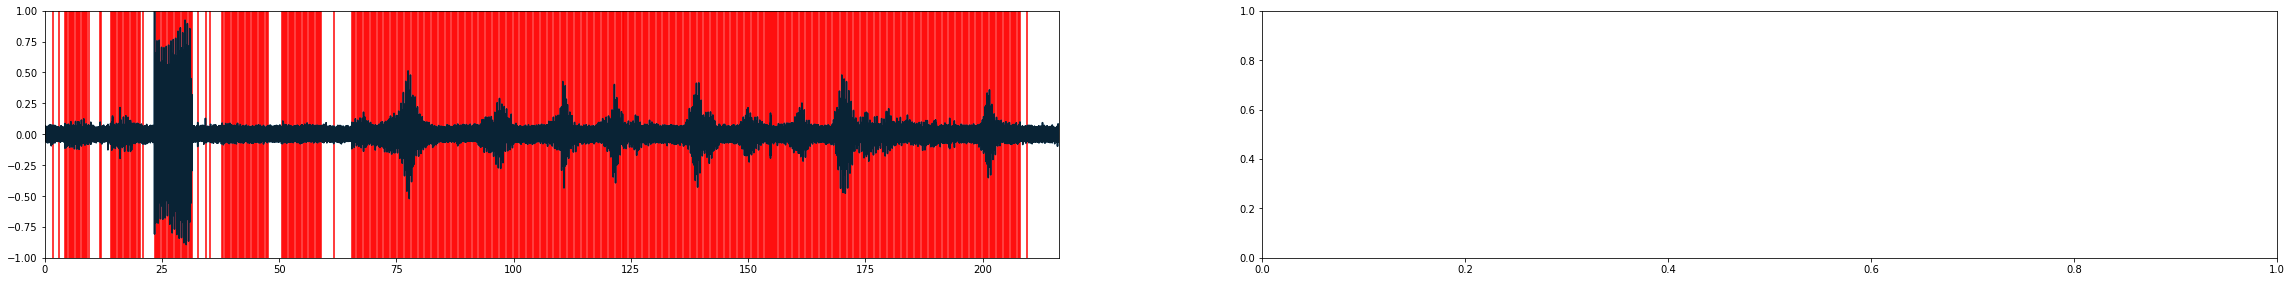

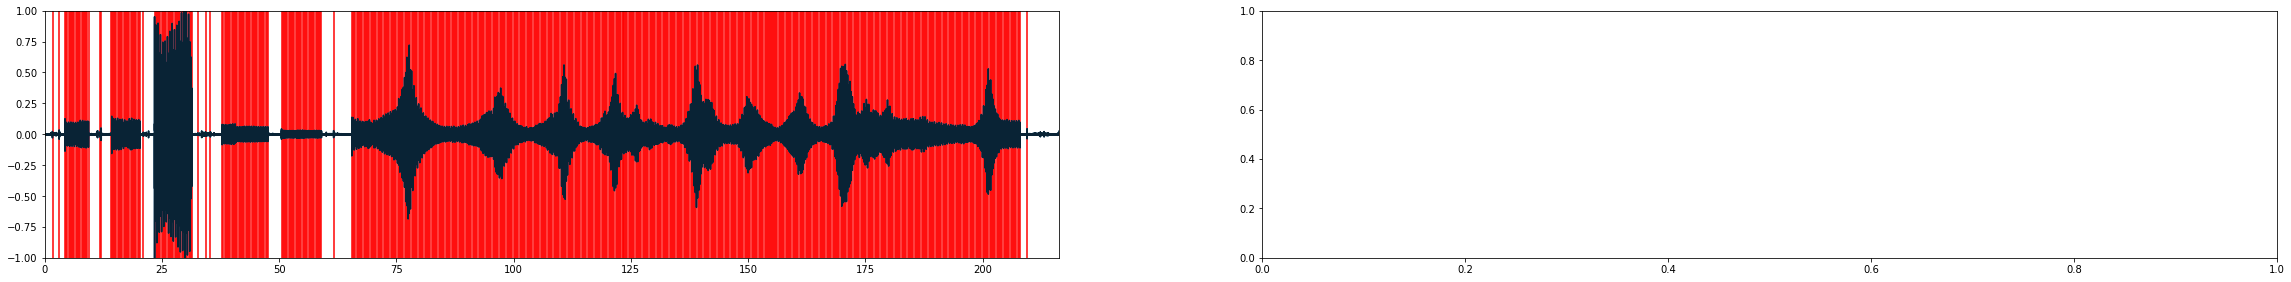

In [6]:

offs = widgets.VBox([widgets.FloatSlider(value=offsets[k], min=-0.1, max=0.1, step=0.00001, readout_format='.5f', description="offset %d"%(k+1), continuous_update=True) for k in range(len(data))])
scale_buttons2 = widgets.ToggleButtons(
    options=['coarse', 'med', 'fine', 'ultrafine'],
    value='med',
    description='scrub speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['1','2','3'])
replot_button2 = widgets.ToggleButton(
    value=False,
    description='replot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def set_ranges(*args):
    for ix, slider in enumerate(offs.children):
        if scale_buttons2.value == scale_buttons2.options[0]:
            scl = 0.5
            slider.min = slider.value-scl
            slider.max = slider.value+scl
        elif scale_buttons2.value == scale_buttons2.options[1]:
            scl = 0.1
            slider.min = slider.value-scl
            slider.max = slider.value+scl
        elif scale_buttons2.value == scale_buttons2.options[2]:
            scl = 0.01
            slider.min = slider.value-scl
            slider.max = slider.value+scl
        elif scale_buttons2.value == scale_buttons2.options[3]:
            scl = 0.001
            slider.min = slider.value-scl
            slider.max = slider.value+scl

def update_offsets(*args):
    global offsets
    for ix, slider in enumerate(offs.children):
        offsets[ix] = slider.value

def replot(**kwargs):
    update_offsets()
    plot(x_ax=x_ax_align, y_ax=y_ax_align, ref=ref,**kwargs)
    
d_map = {str(k):offs.children[k] for k in range(len(offs.children))}
d_map.update({'plot_onsets':fixed(True), 'plot_ref':fixed(True), 'lines':fixed([ix for ix in range(len(data))]), 'x':replot_button2})
out2 = widgets.interactive_output(replot, d_map)
scale_buttons2.observe(set_ranges,'value')
hb = widgets.HBox([offs, widgets.VBox([scale_buttons2, replot_button2])])
display(hb, out2)

FloatRangeSlider(value=(-0.1, 0.1), description='Window range:', max=0.25, min=-0.25, readout_format='.4f', st…

Button(description='update offsets', icon='check', style=ButtonStyle(), tooltip='Click me')

Output()

[-4410, 4410] 2
delay between 0 and 0 (ref) is 0.00001
delay between 1 and 0 (ref) is 0.00489
delay between 2 and 0 (ref) is 0.00189
delay between 3 and 0 (ref) is 0.00459


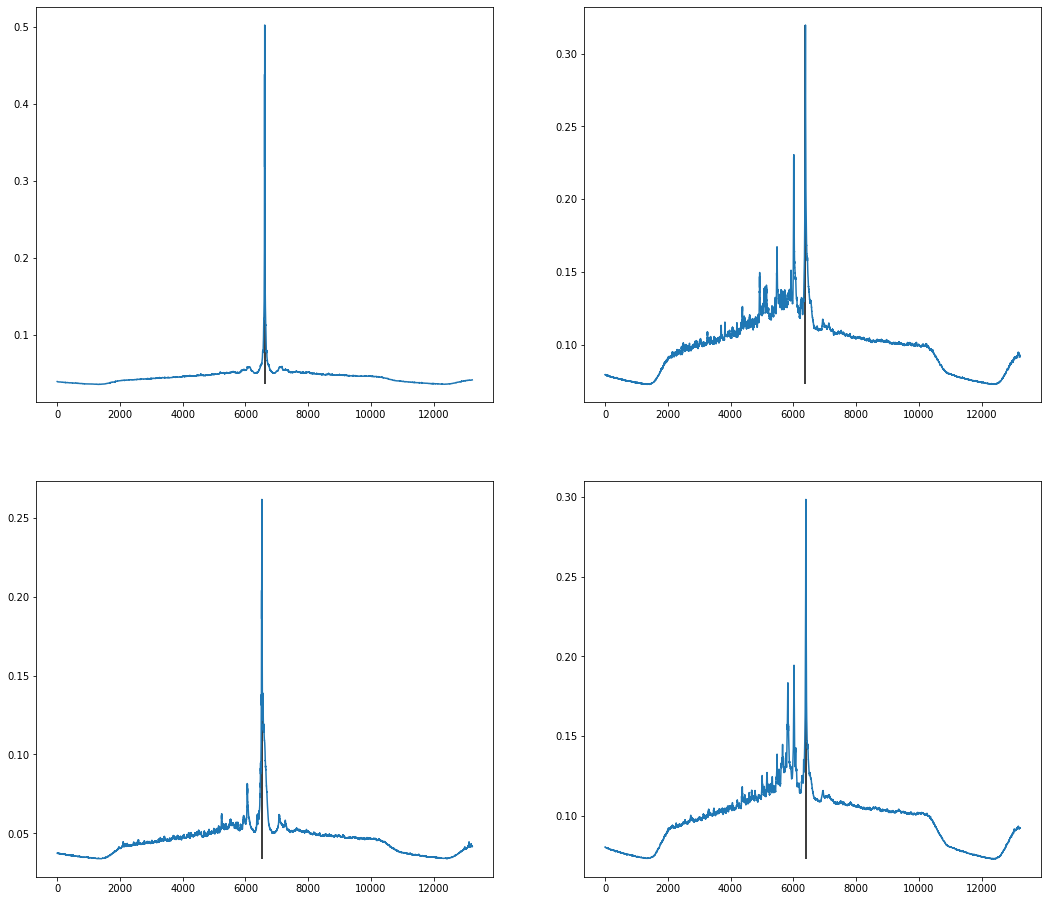

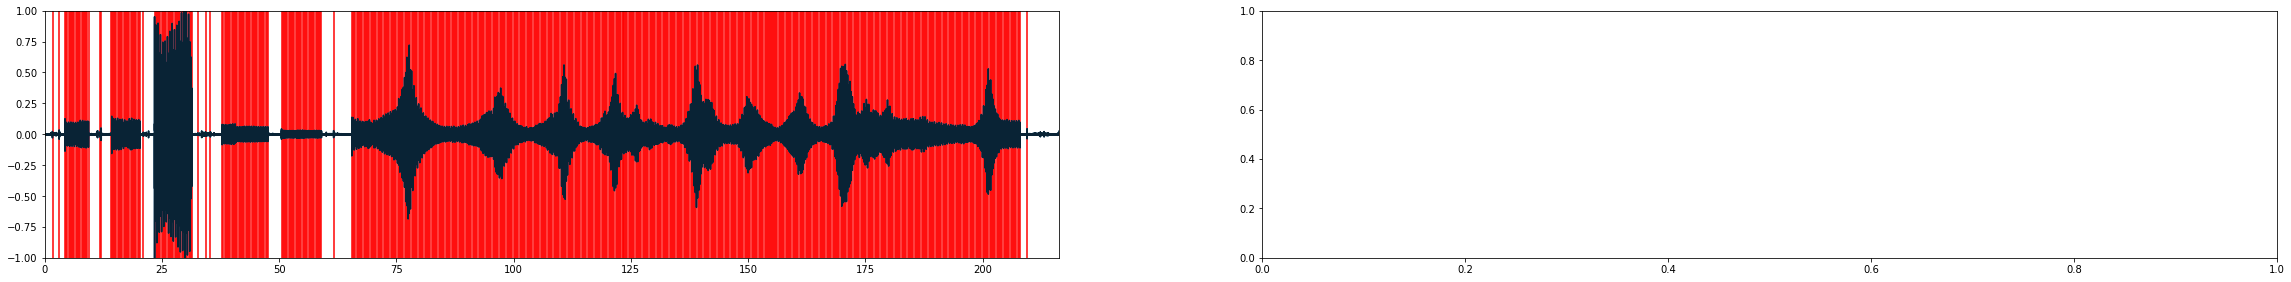

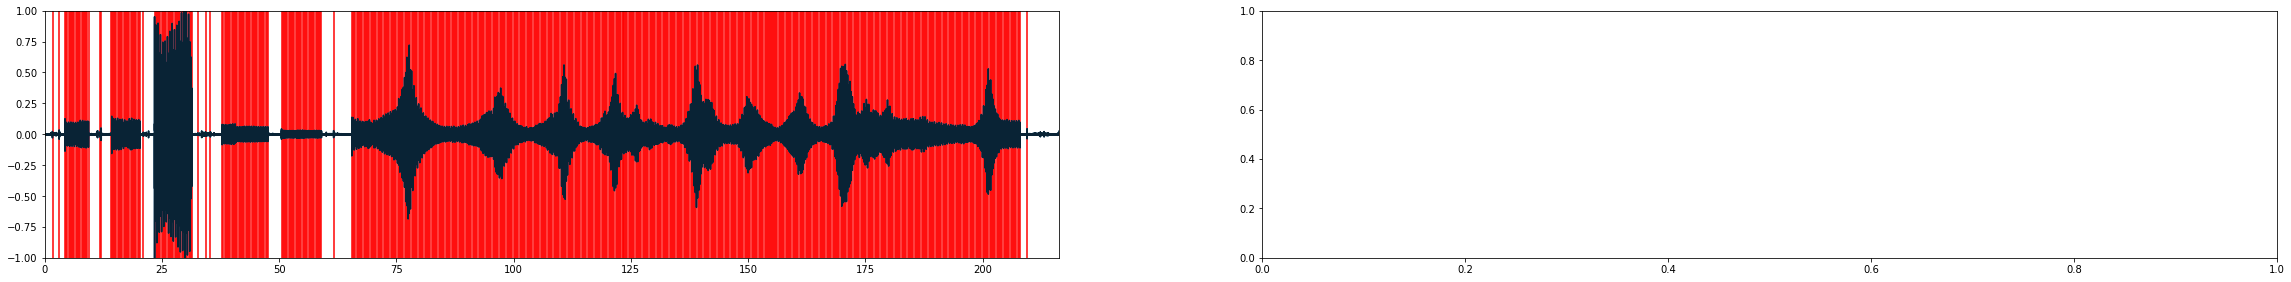

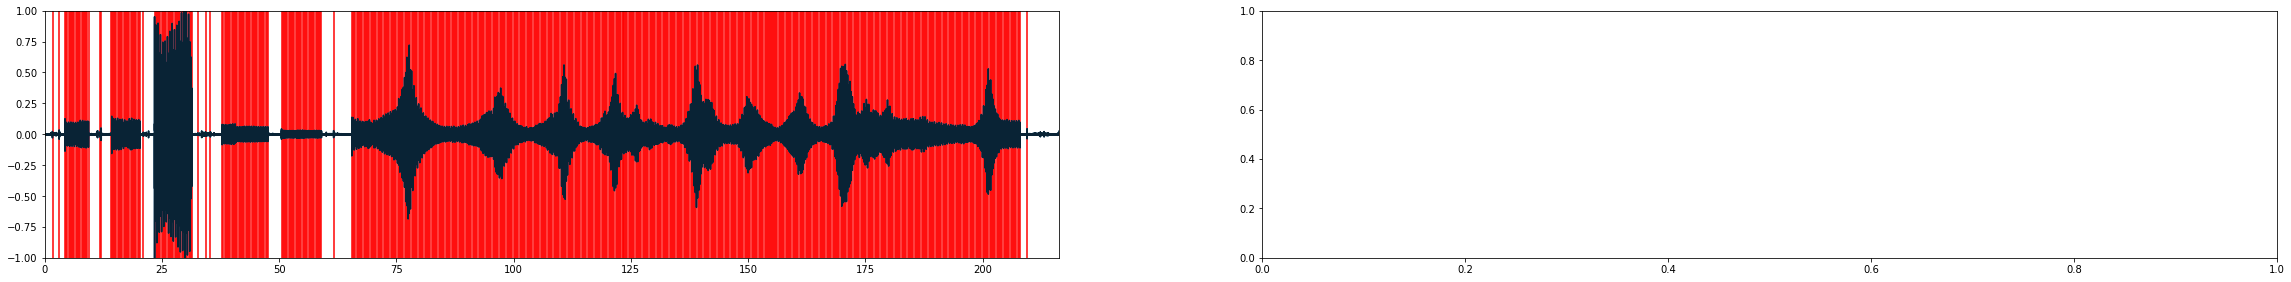

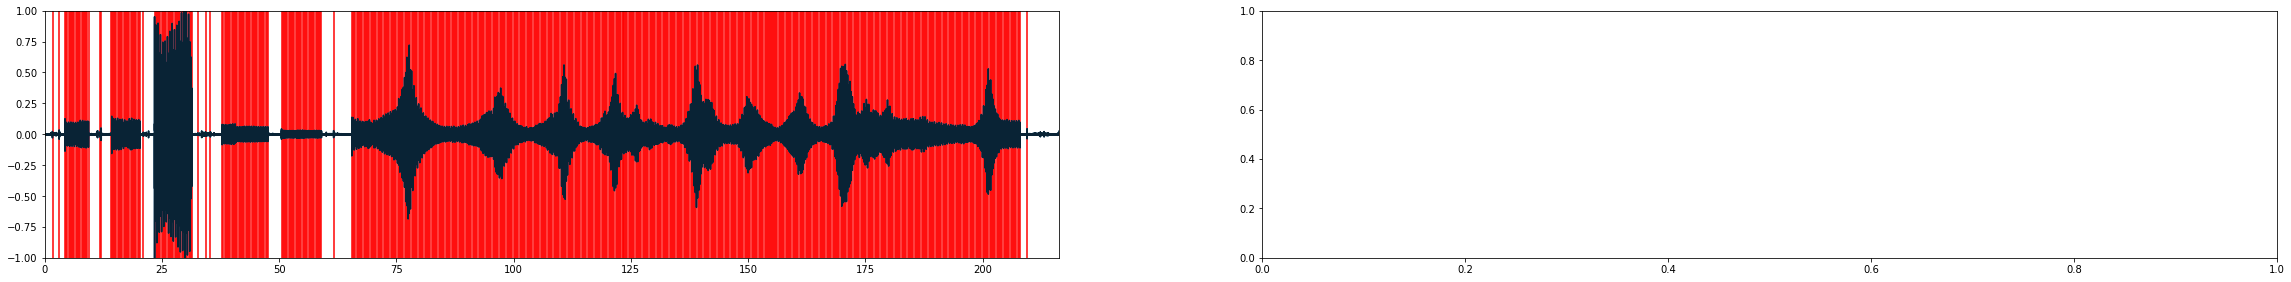

In [7]:
#cross correlate signals

#at each onset, take window (variable) around onset and correlate samples
temp_offsets = []
def corr_ex(window):
    global temp_offsets
    temp_offsets = [0 for k in offsets]
    print(tts(window), len(tts(window)))
    ref_clip = data[ref] 
    onsets = onset_times[ref]
    onsets = onsets[np.logical_and(onsets >= tts(x_ax_align[0]), onsets <= tts(x_ax_align[1]))]
    numonsets = len(onsets)
    f = plt.figure(figsize = (18,16))
    rc = np.ceil(np.sqrt(len(data)))
    for ix in range(len(data)):
#         corr = np.zeros((tts(window[1]-window[0]),))
        delay = 0
        prev_corr = 0
        for onset in onsets:
            ref_w = getwindow(onset, tts(0.25))
            ww = getwindow(onset, tts(window))
            ref_clip = data[ref][ref_w]
            corr=np.correlate(np.abs(ref_clip),np.abs(data[ix][ww+tts(offsets[ix])])*np.max(np.abs(ref_clip))/np.max(np.abs(data[ix][ww+tts(offsets[ix])])), mode="valid")/numonsets + prev_corr
            prev_corr = corr
            delay+= stt(len(corr)/2 - np.argmax(corr))/numonsets
        plt.subplot(rc,rc,ix+1)
        plt.plot(corr)
        plt.vlines(np.argmax(corr),np.min(corr),np.max(corr))
        print("delay between %d and %d (ref) is %0.5f" % (ix,ref, delay))
        temp_offsets[ix]+=delay
    
window_range = widgets.FloatRangeSlider(
    value=[-0.1, 0.1],
    min=-0.25,
    max=0.25,
    step=0.05,
    description='Window range:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')

update_btn = widgets.Button(
    description='update offsets',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check')

out3 = widgets.interactive_output(corr_ex, {'window':window_range})
def update_button(*args):
    global offsets, temp_offsets, offs, out3, out2
    corr_ex(window_range.value)
    local_offsets = offsets
    for ix, slider in enumerate(offs.children):
        local_offsets[ix] += temp_offsets[ix]
        slider.value = local_offsets[ix]
    offsets=local_offsets
    out3.clear_output()
    out2.clear_output(wait=True)
    with out3:
        print('updated:')
        corr_ex(window_range.value)
        plt.show()
    with out2:
        plot(True,True,[ix for ix in range(len(data))],x_ax_align, y_ax_align, ref)
        plt.show()
display(window_range,update_btn, out3)
update_btn.on_click(update_button)

In [15]:
print("Offsets (ms): %.2f, %.2f, %.2f, %.2f" % tuple([o*1e3 for o in offsets]))
print("Offsets (samples)", tts(offsets))
print("'Error' (ms): %.2f, %.2f, %.2f, %.2f" % tuple([to*1000 for to in temp_offsets]))

Offsets (ms): 0.01, 4.89, 1.89, 4.59
Offsets (samples) [0, 215, 83, 202]
'Error' (ms): 0.01, 0.02, 0.01, 0.01


In [16]:
ref = 0
x_ax_tdoa = []
y_ax_tdoa= []
maxx = stt(min([len(data[k]) - tts(offsets[k]) for k in range(len(data))]))-1
def do_settings_tdoa(reference, lns, wrl, wrh, yr, oc, pr, **kwargs):
    global ref, lines, scale, x_ax_tdoa, y_ax_tdoa
    ref = reference
    x_ax_tdoa = [wrl, wrh]
    y_ax_tdoa = yr
    plot(oc,pr,lns, x_ax_tdoa, y_ax_tdoa)

w_range_low2 = widgets.FloatSlider(
    value=0,
    min=0,
    max=maxx,
    step=0.001,
    description='Lower Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
w_range_high2 = widgets.FloatSlider(
    value=maxx,
    min=0,
    max=maxx,
    step=0.001,
    description='Upper Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
scale_buttons3 = widgets.ToggleButtons(
    options=['full','coarse', 'med', 'fine', 'ultrafine'],
    value='full',
    description='scrub speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['1','2','3'])
y_range2 = widgets.FloatRangeSlider(
    value=[-1, 1],
    min=-1,
    max=1,
    step=0.05,
    description='Vertical range:',
    disabled=False,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    readout_format='.4f')
onset_cb2 = widgets.Checkbox(
    value=True,
    description='Plot Onsets',
    disabled=False,
    indent=False)

replot_button2 = widgets.ToggleButton(
    value=False,
    description='replot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def update_range_low2(*args):
    if scale_buttons3.value == scale_buttons3.options[0]:
        w_range_low2.min = 0
        w_range_low2.max = min(maxx, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[1]:
        scl = 15
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[2]:
        scl = 5
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[3]:
        scl = 0.25
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[4]:
        scl = 0.01
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
        
def update_range_high2(*args):
    if scale_buttons3.value == scale_buttons3.options[0]:
        w_range_high2.min = max(0,w_range_low2.value)
        w_range_high2.max = maxx
    elif scale_buttons3.value == scale_buttons3.options[1]:
        scl = 15
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)
    elif scale_buttons3.value == scale_buttons3.options[2]:
        scl = 5
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low2.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)
    elif scale_buttons3.value == scale_buttons3.options[3]:
        scl = 0.25
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low2.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)
    elif scale_buttons3.value == scale_buttons3.options[4]:
        scl = 0.01
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low2.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)

def update_wrange2(*args):
    update_range_low2()
    update_range_high2()
    
rb2 = widgets.VBox([w_range_low2,w_range_high2, onset_cb2, replot_button2])
# rb.layout.width = '50%'
y_range2.layout.width='100px'
ui2 = widgets.HBox([rb2, y_range2, scale_buttons3])
ui2.layout.width='100%'
out4 = widgets.interactive_output(do_settings_tdoa, {'reference':fixed(ref),
                                               'lns':fixed([k for k in range(len(data))]),
                                               'wrl':w_range_low2,
                                               'wrh':w_range_high2,
                                               'yr':y_range2,
                                               'oc':onset_cb2,
                                               'pr':fixed(False),
                                               'rp':replot_button2
                                              })

scale_buttons3.observe(update_wrange2, 'value')
w_range_low2.observe(update_range_high2, 'value')
w_range_high2.observe(update_range_low2, 'value')

display(ui2,out4)

Output()

In [17]:
delays = []
corr_score = []
uncert = []
medians = []
out5 = widgets.Output()
def update_window(*args):
    global window
    chg = args[0]
    window=[-chg.new, chg.new]
    out5.clear_output()
    with out5:
        tdoa(window)
        print("cool")
        plt.show()

def tdoa(window):
    global delays, uncert, corr_score, medians, onset_times, x_ax_tdoa
    onsets = onset_times[ref]
    onsets_in_window = onsets[np.logical_and(onsets >= tts(x_ax_tdoa[0]), onsets <= tts(x_ax_tdoa[1]))]
    delays = np.zeros((len(onsets_in_window),len(onset_times)))
    corr_score = np.zeros((len(onsets_in_window),len(onset_times)))
    uncert = np.zeros((len(onsets_in_window),len(onset_times)))
    medians = np.zeros((len(onsets_in_window),len(onset_times)))
    delays[:,ref] = stt(onsets_in_window)
    
    for d in range(len(data)):
        for ix,onset in enumerate(onsets_in_window):
            ref_w = getwindow(onset, tts(0.25))
            ww = getwindow(onset, tts(window))
            ref_clip = data[ref][ref_w]
            corr=np.correlate(np.abs(ref_clip),np.abs(data[d][ww+tts(offsets[d])]), mode="valid")
            mx = np.argmax(corr)
            if d != ref:
                delays[ix,d] = stt(len(corr)/2 - mx)
            corr_score[ix,d] = np.max(corr)
            uncert[ix,d] = np.std(corr)
            medians[ix,d] = np.median(corr)    
    
corr_window=widgets.FloatLogSlider(
    value=0.1,
    base=2,
    min=-4.5,
    max=-2,
    step=0.01,
    description='windowsize:',
    disabled=False,
    continuous_update=False,
)
corr_window.observe(update_window,'value')
display(corr_window,out5)

FloatLogSlider(value=0.1, base=2.0, continuous_update=False, description='windowsize:', max=-2.0, min=-4.5, st…

Output()

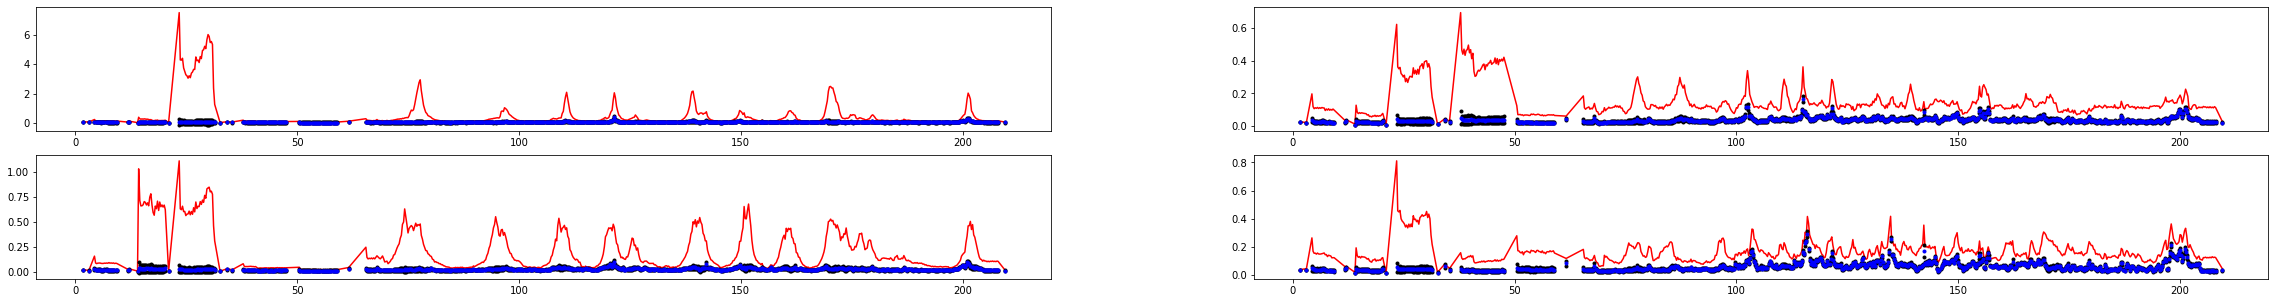

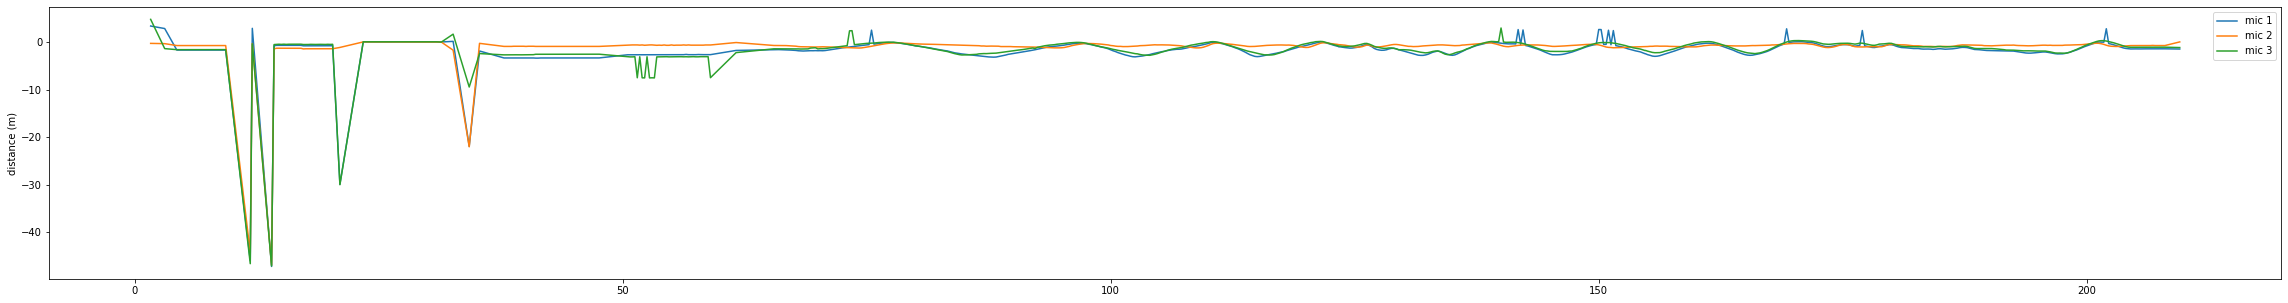

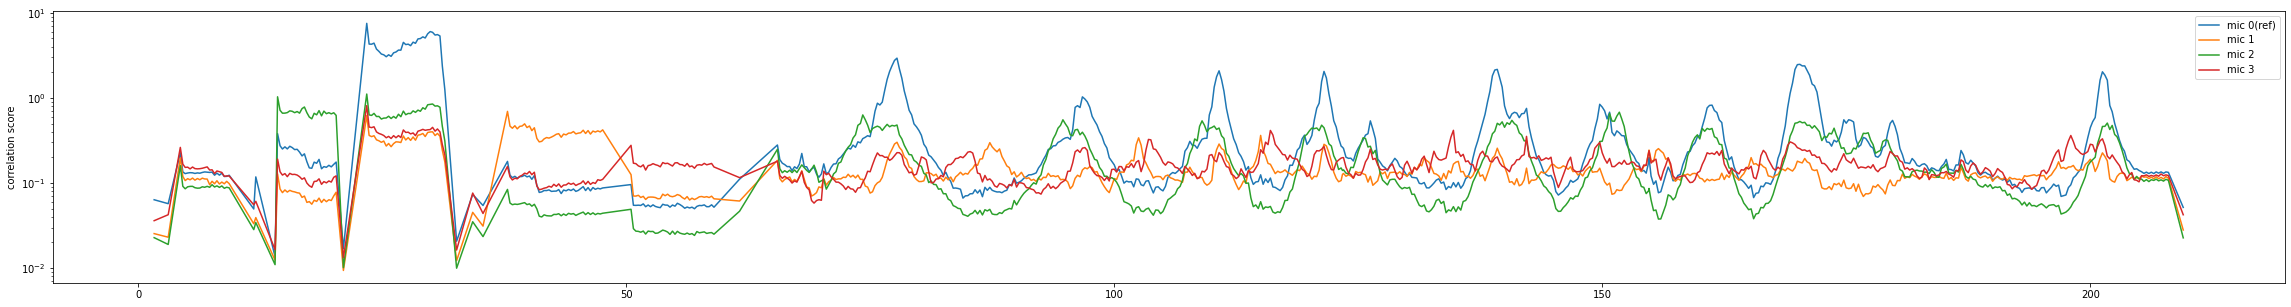

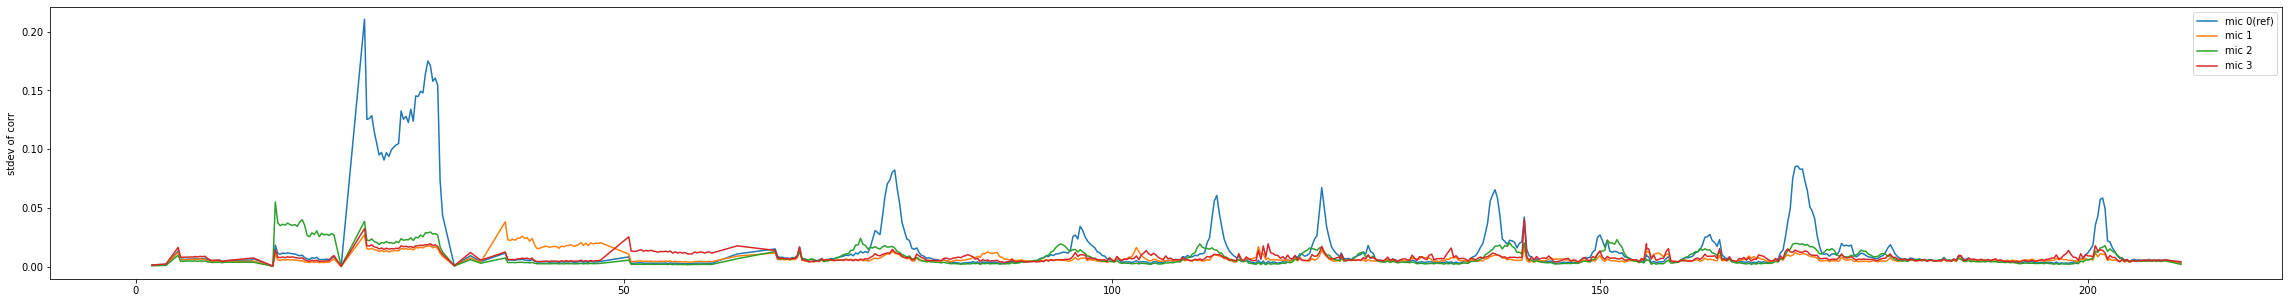

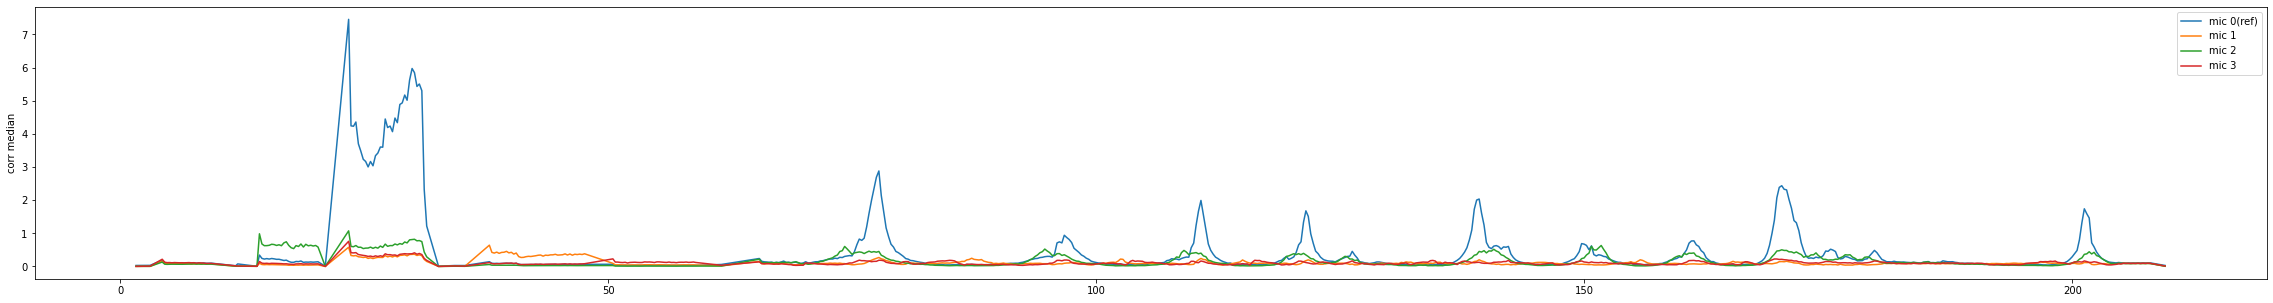

In [18]:
#plot the results
def plotarray(arr, scale=1, logscale=False, ylabel=''):
    newfig(h=5)
    for k in range(arr.shape[1]):
        if k==ref and scale!=1:
            continue
        ln, = plt.plot(delays[:,ref],arr[:,k]*scale)
        plt.yscale('log' if logscale else 'linear')
        label = "mic " + str(k) + ("(ref)" if k==ref else "")
        ln.set_label(label)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

newfig(h=5)
rc = np.ceil(np.sqrt(len(data)))
for d in range(len(data)):
    plt.subplot(rc,rc,d+1)
    plt.plot(delays[:,ref],corr_score[:,d],'r',label='correlation')
    plt.plot(delays[:,ref],medians[:,d]+uncert[:,d],'.k',label='+stdev')
    plt.plot(delays[:,ref],medians[:,d]-uncert[:,d],'.k',label='-stdev')
    plt.plot(delays[:,ref],medians[:,d],'.b',label='median')
plt.show()
plotarray(delays, scale=343, ylabel="distance (m)")
plotarray(corr_score, logscale=True, ylabel="correlation score")
plotarray(uncert, ylabel="stdev of corr")
plotarray(corr_score-medians, ylabel="corr median")

In [21]:
import csv

In [22]:
with open('delays.csv', mode='w') as file:
    file = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(delays[0,:])):
        file.writerow(delays[:,i])


In [ ]:
print(len(delays[0,:]))